## CV Job Matching using Doc2Vec

### Implementation

To match CVs to jobs using Doc2Vec, we first import needed libraries and load job data from a CSV file. We clean up the data, keep only the important columns, and combine them into a new column called 'data.' Then, we break down the words in the 'data' column and tag them with unique IDs using the TaggedDocument class.

Next, we set up the Doc2Vec model with certain settings, like the size of the vector, minimum count, and number of times to run. We create the vocabulary by giving the tagged data to the model, and then train the model on this data.

After training, we save the model for later use. We create perfect resumes from each job description to test our model. To match a resume with a job description, we load the saved model and clean up the resume and job description text. We clean the data, making them lowercase, and removing punctuation, and etc.

Using the trained model, we get the document vectors for the resume and job description. Then, we find the cosine similarity between the two vectors to see how well the resume and the job description match. We do this for both a random resume and the perfect resume. The cosine similarity score is between -1 and 1, with 1 being a perfect match and -1 being no match at all.

By using Doc2Vec and cosine similarity, we can match job descriptions and resumes quickly and effectively. This makes the job application process easier and increases the chances of finding the right person for the job.

Lastly, we use a Gauge chart to show the matching percentage for both scores. This gives users a threshold that they could consider when changing their CV to pass the Application Tracking System (ATS) used by most employers.

### Coding
#### 1. Set up

In [1]:
## Install all dependencies
# !pip install gensim
# !pip install nltk
# !pip install pandas
# !pip install numpy
# !pip install requests
# !pip install PyPDF2
# !pip install termcolor
# !pip install python-docx
# !pip install spacy
# !python -m spacy download en_core_web_sm

In [2]:
# Import libraries
from gensim.models.doc2vec import Doc2Vec, TaggedDocument
from nltk.tokenize import word_tokenize
from numpy.linalg import norm
from termcolor import colored
from docx import Document
import pandas as pd
import numpy as np
import requests
import PyPDF2
import re
import plotly.graph_objects as go
import os
import random
import nltk
import spacy
import json
from docx import Document
from docx.shared import Inches
from spacy.matcher import Matcher
from sklearn.metrics import precision_score, recall_score, f1_score
from sklearn.metrics.pairwise import cosine_similarity
nltk.download('punkt')

[nltk_data] Downloading package punkt to /home/hh1980/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

#### 2. Prepare data
Prepare data from dataset

In [3]:
# Load data
df = pd.read_csv('./dataset/DataScientist.csv')
# Check data
df.head()

,Unnamed: 0,index,Job Title,Salary Estimate,Job Description,Rating,Company Name,Location,Headquarters,Size,Founded,Type of ownership,Industry,Sector,Revenue,Competitors,Easy Apply
0,0,0,Senior Data Scientist,$111K-$181K (Glassdoor est.),"ABOUT HOPPER\n\nAt Hopper, we’re on a mission ...",3.5,Hopper\n3.5,"New York, NY","Montreal, Canada",501 to 1000 employees,2007,Company - Private,Travel Agencies,Travel & Tourism,Unknown / Non-Applicable,-1,-1
1,1,1,"Data Scientist, Product Analytics",$111K-$181K (Glassdoor est.),"At Noom, we use scientifically proven methods ...",4.5,Noom US\n4.5,"New York, NY","New York, NY",1001 to 5000 employees,2008,Company - Private,"Health, Beauty, & Fitness",Consumer Services,Unknown / Non-Applicable,-1,-1
2,2,2,Data Science Manager,$111K-$181K (Glassdoor est.),Decode_M\n\nhttps://www.decode-m.com/\n\nData ...,-1.0,Decode_M,"New York, NY","New York, NY",1 to 50 employees,-1,Unknown,-1,-1,Unknown / Non-Applicable,-1,True
3,3,3,Data Analyst,$111K-$181K (Glassdoor est.),Sapphire Digital seeks a dynamic and driven mi...,3.4,Sapphire Digital\n3.4,"Lyndhurst, NJ","Lyndhurst, NJ",201 to 500 employees,2019,Company - Private,Internet,Information Technology,Unknown / Non-Applicable,"Zocdoc, Healthgrades",-1
4,4,4,"Director, Data Science",$111K-$181K (Glassdoor est.),"Director, Data Science - (200537)\nDescription...",3.4,United Entertainment Group\n3.4,"New York, NY","New York, NY",51 to 200 employees,2007,Company - Private,Advertising & Marketing,Business Services,Unknown / Non-Applicable,"BBDO, Grey Group, Droga5",-1


Since head() fuction does not show all data, we check column names to retain only necessary variables.

In [4]:
# Show column name
df.columns

Index(['Unnamed: 0', 'index', 'Job Title', 'Salary Estimate',
       'Job Description', 'Rating', 'Company Name', 'Location', 'Headquarters',
       'Size', 'Founded', 'Type of ownership', 'Industry', 'Sector', 'Revenue',
       'Competitors', 'Easy Apply'],
      dtype='object')

Keep only some columns to train the model

In [5]:
df =df[['Job Title', 'Job Description', 'Industry', 'Sector']]
df.head()

,Job Title,Job Description,Industry,Sector
0,Senior Data Scientist,"ABOUT HOPPER\n\nAt Hopper, we’re on a mission ...",Travel Agencies,Travel & Tourism
1,"Data Scientist, Product Analytics","At Noom, we use scientifically proven methods ...","Health, Beauty, & Fitness",Consumer Services
2,Data Science Manager,Decode_M\n\nhttps://www.decode-m.com/\n\nData ...,-1,-1
3,Data Analyst,Sapphire Digital seeks a dynamic and driven mi...,Internet,Information Technology
4,"Director, Data Science","Director, Data Science - (200537)\nDescription...",Advertising & Marketing,Business Services


In [6]:
job_title = df['Job Title'].value_counts().reset_index()
job_title

,index,Job Title
0,Data Scientist,274
1,Data Engineer,260
2,Data Analyst,246
3,Senior Data Scientist,91
4,Senior Data Analyst,47
...,...,...
2074,Phoenix Data Science Tutor Jobs,1
2075,Civil Engineer/GIS Data Analyst,1
2076,Principal Device Modeling Engineer,1
2077,SQL/SAS Data Analyst,1


In [7]:
# Create a new column called 'data' and merge the values of the other columns into it
df['data'] = df[['Job Title', 'Job Description', 'Industry', 'Sector']].apply(lambda x: ' '.join(x.dropna().astype(str)), axis=1)
# Drop the individual columns if you no longer need them
df.drop(['Job Title', 'Job Description', 'Industry', 'Sector'], axis=1, inplace=True)
# Preview the updated dataframe
print(df.head())

                                                data
0  Senior Data Scientist ABOUT HOPPER\n\nAt Hoppe...
1  Data Scientist, Product Analytics At Noom, we ...
2  Data Science Manager Decode_M\n\nhttps://www.d...
3  Data Analyst Sapphire Digital seeks a dynamic ...
4  Director, Data Science Director, Data Science ...


#### 3. Tokenize data
We tokenize the words in the 'data' column and tag them with unique identifiers using the TaggedDocument class.

In [8]:
# Tag data
data = list(df['data'])
tagged_data = [TaggedDocument(words = word_tokenize(_d.lower()), tags = [str(i)]) for i, _d in enumerate(data)]

#### 4. Model initialization and vocabulary buiding
Next, we initialize the Doc2Vec model with specific parameters.

**Parameters** of Doc2Vec are as follows: 

- `vector_size`: Dimensionality of the feature vectors. Default: 100.
- `window`: The window refers to the maximum distance between the target word and its context words within a sentence. Default: 5.
- `min_count`: Ignores all words with a total frequency lower than this. Default: 5.
- `epochs`: Number of iterations (epochs) over the corpus. Defaults to 5 for PV-DBOW and 10 for PV-DM.
- `dm`: Defines the training algorithm. If `dm = 1`, the Distributed Memory (PV-DM) model is used. If `dm = 0`, the Distributed Bag of Words (PV-DBOW) model is used. Default: 1 (PV-DM).
- `dbow_words`: If set to 1, trains word vectors (in addition to document vectors) using the PV-DBOW algorithm. Default: 0 (False).
- `dm_mean`: If set to 1, uses the mean of the context word vectors instead of concatenation when inferring vectors in the PV-DM model. Default: 0 (False).
- `dm_concat`: If set to 1, concatenates the document and context word vectors when inferring vectors in the PV-DM model. Default: 0 (False).
- `dm_tag_count`: Expected number of document tags per document, when using the PV-DM algorithm. Default: 1.
- `dbow_tag_count`: Expected number of document tags per document, when using the PV-DBOW algorithm. Default: 1.
- `alpha`: The initial learning rate. Default: 0.025.
- `min_alpha`: The learning rate will linearly drop to `min_alpha` as training progresses. Default: 0.0001.
- `hs`: If set to 1, hierarchical softmax activation function will be used. Default: 0 (Negative Sampling).
- `negative`: If > 0, negative sampling will be used, the int for negative specifies how many "noise words" should be drawn. Default: 5.
- `ns_exponent`: The exponent used to shape the negative sampling distribution. Default: 0.75.


In [9]:
# Model initialization
model = Doc2Vec(vector_size = 50,
min_count = 5,
epochs = 50,
alpha = 0.001
)

In [10]:
# Vocabulary building
model.build_vocab(tagged_data)
# Get the vocabulary keys
keys = model.wv.key_to_index.keys()
# Print the length of the vocabulary keys
print(len(keys))

11885


#### 5. Train and save the model
Train the model on tagged data.

In [11]:
# Train the model
for epoch in range(model.epochs):
    print(f"Training epoch {epoch+1}/{model.epochs}")
    model.train(tagged_data, 
                total_examples=model.corpus_count, 
                epochs=model.epochs)

model.save('cv_job_maching.model')
print("Model saved")

Training epoch 1/50
Training epoch 2/50
Training epoch 3/50
Training epoch 4/50
Training epoch 5/50
Training epoch 6/50
Training epoch 7/50
Training epoch 8/50
Training epoch 9/50
Training epoch 10/50
Training epoch 11/50
Training epoch 12/50
Training epoch 13/50
Training epoch 14/50
Training epoch 15/50
Training epoch 16/50
Training epoch 17/50
Training epoch 18/50
Training epoch 19/50
Training epoch 20/50
Training epoch 21/50
Training epoch 22/50
Training epoch 23/50
Training epoch 24/50
Training epoch 25/50
Training epoch 26/50
Training epoch 27/50
Training epoch 28/50
Training epoch 29/50
Training epoch 30/50
Training epoch 31/50
Training epoch 32/50
Training epoch 33/50
Training epoch 34/50
Training epoch 35/50
Training epoch 36/50
Training epoch 37/50
Training epoch 38/50
Training epoch 39/50
Training epoch 40/50
Training epoch 41/50
Training epoch 42/50
Training epoch 43/50
Training epoch 44/50
Training epoch 45/50
Training epoch 46/50
Training epoch 47/50
Training epoch 48/50
T

#### 6. Generate perfect resumes for job description for validation

In [12]:
# Load the spaCy English language model
nlp = spacy.load("en_core_web_sm")

# Extract Job Requirements
def extract_requirements(job_description):
    # Use spaCy to extract skills, experience, and education
    doc = nlp(job_description)
    skills = extract_skills(doc)
    experience = extract_experience(doc)
    education = extract_education(doc)

    return {
        'skills': skills,
        'experience': experience,
        'education': education
    }

def extract_skills(doc):
    # Define patterns to match skills
    skill_patterns = [
        [{'POS': 'NOUN'}, {'LOWER': 'skills'}],
        [{'POS': 'NOUN'}, {'LOWER': 'experience'}, {'LOWER': 'in'}],
        [{'POS': 'NOUN'}, {'POS': 'CCONJ'}, {'POS': 'NOUN'}],  # e.g., "Python and SQL"
        [{'POS': 'NOUN'}, {'POS': 'PART'}, {'POS': 'NOUN'}],   # e.g., "Machine Learning"
        [{'POS': 'NOUN'}, {'POS': 'NOUN'}]                     # e.g., "Data Analysis"
    ]
    matcher = Matcher(nlp.vocab)
    matcher.add("SKILLS", skill_patterns)

    skills = []
    matches = matcher(doc)
    for match_id, start, end in matches:
        span = doc[start:end]
        skills.append(span.text)

    # Remove duplicates and join skills with commas
    skills = list(set(skills))
    return ', '.join(skills)

def extract_experience(doc):
    # Define patterns to match experience requirements
    exp_patterns = [
        [{'LOWER': 'experience'}, {'POS': 'NUM'}, {'LOWER': 'years'}],
        [{'LOWER': 'minimum'}, {'POS': 'NUM'}, {'LOWER': 'years'}, {'LOWER': 'experience'}]
    ]
    matcher = Matcher(nlp.vocab)
    matcher.add("EXPERIENCE", exp_patterns)

    experience = []
    matches = matcher(doc)
    for match_id, start, end in matches:
        span = doc[start:end]
        experience.append(span.text)

    return experience

def extract_education(doc):
    # Define patterns to match education requirements
    edu_patterns = [
        [{'LOWER': 'degree'}, {'POS': 'NOUN'}],
        [{'LOWER': 'bachelor'}, {'POS': 'NOUN'}],
        [{'LOWER': 'master'}, {'POS': 'NOUN'}]
    ]
    matcher = Matcher(nlp.vocab)
    matcher.add("EDUCATION", edu_patterns)

    education = []
    matches = matcher(doc)
    for match_id, start, end in matches:
        span = doc[start:end]
        education.append(span.text)

    return education

In [13]:
# Fill the Resume Template
def fill_resume_template(job_description, template):
    # Extract requirements from job description
    requirements = extract_requirements(job_description)

    # Fill the template with the requirements
    resume = template.copy()
    resume['Skills'] = ', '.join(requirements['skills'])
    resume['Work Experience'] = [create_work_experience(req, requirements['skills']) for req in requirements['experience']]
    resume['Education'] = create_education(requirements['education'][0]) if requirements['education'] else None

    # Add relevant sections for data science roles
    resume['Programming Languages'] = ', '.join(get_programming_languages(requirements['skills']))
    resume['Data Science Skills'] = ', '.join(get_data_science_skills(requirements['skills']))
    resume['Tools & Technologies'] = ', '.join(get_tools_and_technologies(requirements['skills']))

    # Differentiate resumes based on specific requirements
    resume['Domain Expertise'] = ', '.join(get_domain_expertise(job_description))
    resume['Specialized Skills'] = ', '.join(get_specialized_skills(job_description))

    return resume

def create_work_experience(experience_requirement, skills):
    # Parse the experience requirement
    match = re.search(r'(\d+)\s*years', experience_requirement, re.I)
    if match:
        years = int(match.group(1))
        position = 'Data Scientist' if 'data scientist' in experience_requirement.lower() else 'Relevant Position'
        return {
            'Position': position,
            'Company': 'Relevant Company',
            'Duration': f'{years} years',
            'Responsibilities': ', '.join(skills)
        }
    return None

def create_education(education_requirement):
    # Parse the education requirement
    degree_match = re.search(r'(bachelor|master|phd)\s*(degree|\'s)', education_requirement, re.I)
    if degree_match:
        degree_type = degree_match.group(1).capitalize()
        return {
            'Degree': f'{degree_type} Degree',
            'Field': 'Data Science, Statistics, Computer Science, or related field',
            'University': 'Relevant University'
        }
    return None

def get_programming_languages(skills):
    languages = ['Python', 'R', 'SQL', 'Java', 'C++', 'C', 'Scala', 'Julia', 'MATLAB', 'JavaScript', 'Ruby', 'Go', 'Kotlin', 'PHP', 'Swift', 'TypeScript', 'Perl', 'Bash', 'Shell Scripting', 'SAS', 'PL/SQL', 'VBA', 'F#', 'Clojure', 'Erlang', 'Rust', 'PowerShell', 'Dart','Hive', 'Objective-C']

    return [lang for lang in languages if lang.lower() in [skill.lower() for skill in skills]]

def get_data_science_skills(skills):
    data_science_skills = [
    'Machine Learning', 'Statistical Modeling', 'Data Analysis', 'Data Visualization',
    'Deep Learning', 'Natural Language Processing', 'Computer Vision', 'Reinforcement Learning',
    'Predictive Modeling', 'Time Series Analysis', 'Bayesian Methods', 'Survival Analysis',
    'Experiment Design', 'A/B Testing', 'Dimensionality Reduction', 'Cluster Analysis',
    'Anomaly Detection', 'Neural Networks', 'Optimization Techniques', 'Feature Engineering',
    'Model Validation', 'Decision Trees', 'Random Forests', 'Gradient Boosting Machines',
    'Support Vector Machines', 'Ensemble Methods', 'Recommendation Systems', 'Graph Analytics',
    'Natural Language Generation', 'Sentiment Analysis', 'Text Mining', 'Image Processing',
    'Speech Recognition', 'Pattern Recognition', 'Big Data Technologies', 'Causal Inference',
    'Monte Carlo Methods', 'Simulation Techniques', 'Scalable Data Systems', 'Cloud Computing',
    'Ethics in Data Science', 'Data Governance', 'Data Privacy', 'Data Security', 'Data Quality Management',
    'Data Wrangling', 'Data Integration', 'Business Intelligence', 'Operational Research', 'Geospatial Analysis',
    'Bioinformatics', 'Healthcare Analytics', 'Financial Modeling', 'Customer Analytics', 'Retail Analytics',
    'Sports Analytics', 'Algorithm Development'
]

    return [skill for skill in data_science_skills if any(s.lower() in skill.lower() for s in skills)]

def get_tools_and_technologies(skills):
    tools_and_technologies = [
    'Pandas', 'NumPy', 'Scikit-learn', 'TensorFlow', 'PyTorch', 'Keras', 'Spark', 'Hadoop', 'Hive', 'Impala',
    'MapReduce', 'Pig', 'MongoDB', 'Postgres', 'NoSQL', 'MySQL', 'Oracle', 'SQL Server', 'Beautifulsoup', 'Selenium',
    'Scrapy', 'HTML5', 'JavaScript', 'CSS', 'R Shiny', 'Tableau', 'Power BI', 'D3.js', 'Matplotlib', 'Seaborn',
    'Plotly', 'Bokeh', 'ggplot2', 'Dask', 'Flink', 'Airflow', 'Luigi', 'Docker', 'Kubernetes', 'Jupyter',
    'Zeppelin', 'Google BigQuery', 'Amazon Redshift', 'Azure Data Lake', 'Snowflake', 'Elasticsearch', 'Kibana',
    'Logstash', 'Cassandra', 'Redis', 'Apache Kafka', 'RabbitMQ', 'Git', 'SVN', 'Jenkins', 'CI/CD Pipelines',
    'Ansible', 'Terraform', 'Vault', 'Prometheus', 'Grafana', 'Apache Beam', 'Apache Storm', 'Neo4j', 'GraphQL',
    'REST APIs', 'SOAP APIs', 'FastAPI', 'Flask', 'Django', 'OpenCV', 'scipy', 'Statsmodels', 'SymPy', 'XGBoost',
    'LightGBM', 'CatBoost', 'MLflow', 'Tidyverse', 'Dash', 'Streamlit', 'Cytoscape.js', 'Vega-Lite', 'Altair',
    'Apache Solr', 'JanusGraph', 'ArangoDB', 'Apache Nifi', 'Apache Sqoop', 'Apache Druid', 'Qlik Sense', 'Looker',
    'Apache Superset', 'Metabase', 'SAS', 'SPSS', 'Stata', 'Vowpal Wabbit', 'Alteryx', 'KNIME'
]

    return [tool for tool in tools_and_technologies if any(s.lower() in tool.lower() for s in skills)]

def get_domain_expertise(job_description):
    domains = [
    'Healthcare', 'Finance', 'Retail', 'Marketing', 'Telecommunications', 'Manufacturing', 'Energy',
    'Transportation', 'Government', 'Defense', 'Security', 'Education', 'Real Estate', 'Sports',
    'Entertainment', 'Media', 'Tourism', 'Hospitality', 'Legal', 'Insurance', 'Biotechnology',
    'Pharmaceuticals', 'Agriculture', 'Food and Beverage', 'Environmental Science', 'Marine Science',
    'Urban Planning', 'Public Health', 'E-commerce', 'Automotive', 'Aerospace', 'Utilities',
    'Non-profit Sector', 'Human Resources', 'Supply Chain', 'Logistics', 'Construction',
    'Mining', 'Oil and Gas', 'Publishing', 'Fintech', 'Edtech', 'Medtech', 'Adtech', 'Cryptocurrency',
    'Blockchain', 'Gaming', 'Virtual Reality', 'Augmented Reality', 'Machine Learning as a Service',
    'Cloud Services', 'IoT (Internet of Things)', 'Smart Cities', 'Cybersecurity', 'Forensics',
    'Demography', 'Economic Analysis', 'Social Media', 'Content Creation', 'Digital Health', 'Telemedicine'
]

    return [domain for domain in domains if domain.lower() in job_description.lower()]

def get_specialized_skills(job_description):
    specialized_skills = [
    'Recommender Systems', 'Natural Language Processing', 'Computer Vision', 'Time Series Analysis',
    'Forecasting', 'Clustering', 'Ensemble Methods', 'Bayesian Methods', 'Neural Networks',
    'Deep Learning', 'Reinforcement Learning', 'Collaborative Filtering', 'Web Scraping',
    'Anomaly Detection', 'Dimensionality Reduction', 'Feature Selection', 'Feature Engineering',
    'Model Deployment', 'Model Monitoring', 'Model Optimization', 'Hyperparameter Tuning',
    'Data Imputation', 'Data Normalization', 'Data Labeling', 'Sentiment Analysis', 'Text Mining',
    'Image Recognition', 'Speech Recognition', 'Audio Analysis', 'Signal Processing',
    'Genetic Algorithms', 'Optimization Algorithms', 'Simulation', 'Statistical Inference',
    'Causal Analysis', 'Graph Analytics', 'Social Network Analysis', 'Biostatistics',
    'Epidemiology Modeling', 'Credit Risk Modeling', 'Fraud Detection', 'Algorithmic Trading',
    'Robotics', 'Quantum Computing', 'Privacy-preserving ML', 'Federated Learning',
    'Transfer Learning', 'Multi-task Learning', 'Geospatial Analysis', 'Remote Sensing',
    'Computer-Aided Diagnosis', 'Precision Medicine', 'Blockchain Analytics', 'IoT Data Analysis',
    'Predictive Maintenance', 'Supply Chain Analytics', 'Real-Time Data Processing',
    'Customer Segmentation', 'Market Basket Analysis', 'Churn Prediction'
]

    return [skill for skill in specialized_skills if any(s.lower() in job_description.lower() for s in skill.split())]

In [14]:
# Create a Resume Template
resume_template = {
    'Personal Information': {
        'Name': '',
    },
    'Skills': '',
    'Work Experience': [],
    'Education': {},
}

In [15]:
# Generate Perfect Resumes
perfect_resumes = []
for job_description in df['data']:
    perfect_resume = fill_resume_template(job_description, resume_template)
    perfect_resumes.append(perfect_resume)

In [16]:
# Create a directory to save the resumes
save_dir = 'perfect_resumes'
os.makedirs(save_dir, exist_ok=True)

# Save each perfect resume as a .docx file
for i, resume in enumerate(perfect_resumes):
    doc = Document()
    
    # Add personal information
    doc.add_heading(resume['Personal Information']['Name'], 0)
    
    # Add skills
    doc.add_heading('Skills', level=1)
    doc.add_paragraph(resume['Skills'])
    
    # Add work experience
    doc.add_heading('Work Experience', level=1)
    for exp in resume['Work Experience']:
        if exp:
            doc.add_paragraph(f"{exp['Position']} at {exp['Company']} ({exp['Duration']})")
            doc.add_paragraph(exp['Responsibilities'])
            doc.add_paragraph()
    
    # Add education
    if resume['Education']:
        doc.add_heading('Education', level=1)
        doc.add_paragraph(f"{resume['Education']['Degree']} in {resume['Education']['Field']}")
        doc.add_paragraph(f"{resume['Education']['University']}")
    
    # Add additional sections
    if resume['Programming Languages']:
        doc.add_heading('Programming Languages', level=1)
        doc.add_paragraph(resume['Programming Languages'])
    
    if resume['Data Science Skills']:
        doc.add_heading('Data Science Skills', level=1)
        doc.add_paragraph(resume['Data Science Skills'])
    
    if resume['Tools & Technologies']:
        doc.add_heading('Tools & Technologies', level=1)
        doc.add_paragraph(resume['Tools & Technologies'])
    
    if resume['Domain Expertise']:
        doc.add_heading('Domain Expertise', level=1)
        doc.add_paragraph(resume['Domain Expertise'])
    
    if resume['Specialized Skills']:
        doc.add_heading('Specialized Skills', level=1)
        doc.add_paragraph(resume['Specialized Skills'])
    
    # Save the document
    save_path = os.path.join(save_dir, f"perfect_resume_{i+1}.docx")
    doc.save(save_path)
    print(f"Perfect resume {i+1} saved as {save_path}")


Perfect resume 1 saved as perfect_resumes/perfect_resume_1.docx
Perfect resume 2 saved as perfect_resumes/perfect_resume_2.docx
Perfect resume 3 saved as perfect_resumes/perfect_resume_3.docx
Perfect resume 4 saved as perfect_resumes/perfect_resume_4.docx
Perfect resume 5 saved as perfect_resumes/perfect_resume_5.docx
Perfect resume 6 saved as perfect_resumes/perfect_resume_6.docx
Perfect resume 7 saved as perfect_resumes/perfect_resume_7.docx
Perfect resume 8 saved as perfect_resumes/perfect_resume_8.docx
Perfect resume 9 saved as perfect_resumes/perfect_resume_9.docx
Perfect resume 10 saved as perfect_resumes/perfect_resume_10.docx
Perfect resume 11 saved as perfect_resumes/perfect_resume_11.docx
Perfect resume 12 saved as perfect_resumes/perfect_resume_12.docx
Perfect resume 13 saved as perfect_resumes/perfect_resume_13.docx
Perfect resume 14 saved as perfect_resumes/perfect_resume_14.docx
Perfect resume 15 saved as perfect_resumes/perfect_resume_15.docx
Perfect resume 16 saved as p

#### 7. Inputs of CV and JD

- **Resume**:

Get a random resume from our resume dataset

In [17]:
# Get a list of all .docx resume files
resumes = [f for f in os.listdir('./dataset/resumes') if f.endswith('.docx')]

# Select a random .docx file
random_resume = random.choice(resumes)

# Create a Document object
doc = Document(os.path.join('./dataset/resumes', random_resume))

# Extract text
resume = ""
for para in doc.paragraphs:
    resume += para.text
    
print(resume)

Avanthi KattaSr. Business AnalystPh No: 916-282-9259Email ID: sam@vishconsultingservices.comSUMMARYOver Seven years of experience as a Sr. Business Analyst/Quality Analyst.Solid understanding of Business Requirement gathering, Business Process flow, Business Process Modeling and Analysis, design documentation. Experience in all phases of the Software Development Life Cycle (SDLC) including Requirement gathering, Design, Development, Testing and Deployment.Organized Joint Application Development (JAD), workshops and interview sessions.Expertise in Documentation and Review of Software and Business/Technical Requirement Documents. Managed complex business initiatives to balance requirements for functionality, efficiency and quality. Excellent knowledge of Health Insurance Portability and Accountability Act (HIPAA) transaction, code set rules such as EDI 837,270,271,276,277,834,835, NCPDP and ICD9-ICD10.Experienced with Rational tools like ReqPro, Clearquest, Clear Case, Rational soda, Rat

- **Job Description**:

Get a random JD from dataset

In [32]:
# Select a random JD from the dataset
random_jd = random.choice(df['data'])

In [33]:
# Find the corresponding perfect resume for the random JD
perfect_resume = perfect_resumes[df['data'].tolist().index(random_jd)]

- **Develop a function to pre-process input text**:

In [34]:
def preprocess_text(text):
    # Remove URLs
    text = re.sub('http\S+\s*', ' ', text)

    # Remove RT and cc
    text = re.sub('RT|cc', ' ', text)

    # Remove hashtags
    text = re.sub('#\S+', '', text)

    # Remove mentions
    text = re.sub('@\S+', '  ', text)
    
    # Convert the text to lowercase
    text = text.lower()
    
    # Remove punctuation from the text
    text = re.sub('[^a-z]', ' ', text)
    
    # Remove numerical values from the text
    text = re.sub(r'\d+', '', text)
    
    # Remove extra whitespaces
    text = ' '.join(text.split())
    
    return text

In [35]:
# Convert the perfect_resume dictionary to a string
perfect_resume_str = json.dumps(perfect_resume)

# Apply preprocess function to CV, JD, and perfect resume
input_CV = preprocess_text(resume)
input_JD = preprocess_text(random_jd)
perfect_resume_text = preprocess_text(perfect_resume_str)

#### 8. Matching
Using the trained model, we infer the document vectors for the resume and job description. Then, we calculate the cosine similarity between the two vectors to determine the match between the resume and the job description.

In [36]:
# Function to calculate cosine similarity
def calculate_similarity(vector1, vector2):
    return cosine_similarity([vector1], [vector2])[0][0]

# Infer vectors for the random resume, random JD, and perfect resume
random_resume_vector = model.infer_vector(word_tokenize(input_CV))
random_jd_vector = model.infer_vector(word_tokenize(input_JD))
perfect_resume_vector = model.infer_vector(word_tokenize(perfect_resume_text))

# Calculate similarity scores
random_resume_similarity = calculate_similarity(random_resume_vector, random_jd_vector)
perfect_resume_similarity = calculate_similarity(perfect_resume_vector, random_jd_vector)


#### 9. Visualization

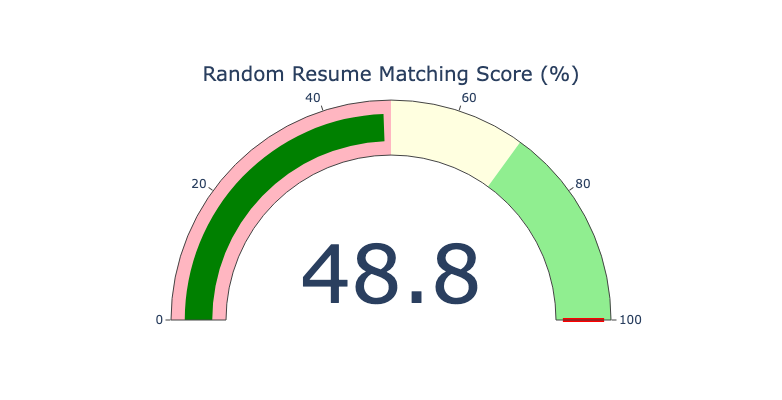

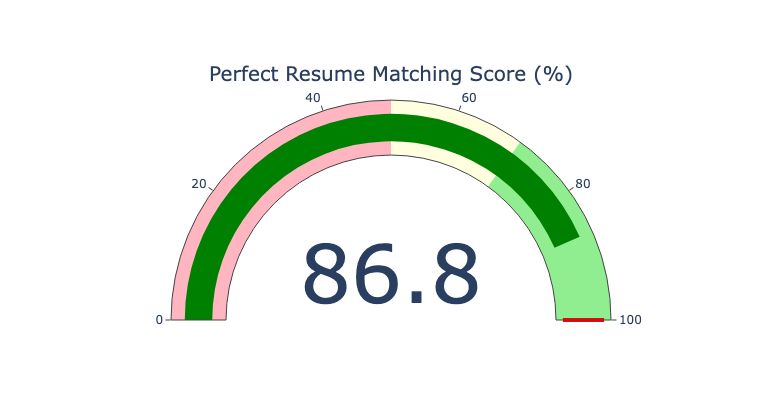


Random Resume Matching Score: 48.8427072763443 %
Perfect Resume Matching Score: 86.76900267601013 %
Low chance, need to modify your CV!


In [37]:
# Visualization
fig1 = go.Figure(go.Indicator(
    mode="gauge+number",
    value=random_resume_similarity * 100,
    title={'text': "Random Resume Matching Score (%)"},
    gauge={
        'axis': {'range': [0, 100]},
        'steps': [
            {'range': [0, 50], 'color': "#FFB6C1"},
            {'range': [50, 70], 'color': "#FFFFE0"},
            {'range': [70, 100], 'color': "#90EE90"}
        ],
        'threshold': {'line': {'color': "red", 'width': 4}, 'thickness': 0.75, 'value': 100}
    }
))

fig1.update_layout(width=400, height=400)  # Adjust the width and height as desired
fig1.show()

fig2 = go.Figure(go.Indicator(
    mode="gauge+number",
    value=perfect_resume_similarity * 100,
    title={'text': "Perfect Resume Matching Score (%)"},
    gauge={
        'axis': {'range': [0, 100]},
        'steps': [
            {'range': [0, 50], 'color': "#FFB6C1"},
            {'range': [50, 70], 'color': "#FFFFE0"},
            {'range': [70, 100], 'color': "#90EE90"}
        ],
        'threshold': {'line': {'color': "red", 'width': 4}, 'thickness': 0.75, 'value': 100}
    }
))

fig2.update_layout(width=400, height=400)  # Adjust the width and height as desired
fig2.show()

# Print results
print("\nRandom Resume Matching Score:", random_resume_similarity * 100, "%")
print("Perfect Resume Matching Score:", perfect_resume_similarity * 100, "%")

if random_resume_similarity < 0.5:
    print(colored("Low chance, need to modify your CV!", "red", attrs=["bold"]))
elif random_resume_similarity >= 0.5 and random_resume_similarity < 0.7:
    print(colored("Good chance but you can improve further!", "yellow", attrs=["bold"]))
else:
    print(colored("Excellent! You can submit your CV.", "green", attrs=["bold"]))
